1. Pemrosesan Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Set style untuk plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


Pembersihan Data

Mengidentifikasi dan menangani missing values menggunakan imputasi median.
Menghapus kolom yang tidak relevan.
Encoding Kategorikal

Kolom jenis_ikan dikonversi menjadi format numerik menggunakan Label Encoding.
Normalisasi Data

Data numerik dinormalisasi menggunakan StandardScaler untuk meningkatkan performa model.

In [2]:
# Load dataset
df = pd.read_csv('produksi2018_2022.csv')

# Tampilkan beberapa baris pertama
print(df.head())

# Informasi dasar tentang dataset
print(df.info())

# Statistik deskriptif
print(df.describe())

# Cek missing values
print(df.isnull().sum())


                   jenis_ikan  Januari  Februari  Maret   April    Mei  \
0        Albakora    Albacore  1301.00       0.0  0.000  7400.0  355.0   
1              Albakora [ALB]     0.00       0.0  0.000     0.0    0.0   
2              Albakora [ALB]   132.54     608.0  2.454   272.0   23.0   
3  Alu-alu/ Manggilala/ Pucul     0.00       0.0  0.000     0.0    0.0   
4  Alu-alu/ Manggilala/ Pucul     0.00     150.0  0.000     0.0    0.0   

      Juni  Juli  Agustus  September  Oktober  November  Desember  Tahun  \
0  500.000   0.0      0.0        0.0      0.0     0.000     0.000   2018   
1    0.000   0.0    193.0      528.0      0.0    29.000    24.000   2021   
2   19.631  50.0     23.0      157.0    667.0     1.098     4.455   2022   
3    0.000   0.0      0.0      150.0      0.0     0.000     1.000   2020   
4  940.000   0.0      0.0        0.0      0.0     0.000     0.000   2021   

   Total_Produksi_Tahunan  Growth_Rate  Produksi_Tahun_Lalu  \
0                0.000540          

In [3]:
# Identifikasi kolom dengan missing values
missing_cols = df.columns[df.isnull().any()].tolist()
print(f"Kolom dengan missing values: {missing_cols}")

# Imputasi missing values menggunakan median (lebih robust terhadap outliers)
for col in missing_cols:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)
    print(f"Missing values di kolom '{col}' diimputasi dengan median: {median_val}")

# Konfirmasi bahwa tidak ada lagi missing values
print(df.isnull().sum().any())


Kolom dengan missing values: ['Growth_Rate', 'Produksi_Tahun_Lalu']
Missing values di kolom 'Growth_Rate' diimputasi dengan median: 5.438424961627485e-05
Missing values di kolom 'Produksi_Tahun_Lalu' diimputasi dengan median: 0.0003556178436414
False


In [4]:
# Encode kolom 'jenis_ikan' menggunakan Label Encoding
label_encoder = LabelEncoder()
df['jenis_ikan_encoded'] = label_encoder.fit_transform(df['jenis_ikan'])

# Tampilkan beberapa baris pertama setelah encoding
print(df[['jenis_ikan', 'jenis_ikan_encoded']].head())

# Hapus kolom 'jenis_ikan' yang tidak lagi diperlukan
df.drop('jenis_ikan', axis=1, inplace=True)

# Lihat info dataset setelah encoding
print(df.info())


                   jenis_ikan  jenis_ikan_encoded
0        Albakora    Albacore                   0
1              Albakora [ALB]                   1
2              Albakora [ALB]                   1
3  Alu-alu/ Manggilala/ Pucul                   2
4  Alu-alu/ Manggilala/ Pucul                   2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Januari                 163 non-null    float64
 1   Februari                163 non-null    float64
 2   Maret                   163 non-null    float64
 3   April                   163 non-null    float64
 4   Mei                     163 non-null    float64
 5   Juni                    163 non-null    float64
 6   Juli                    163 non-null    float64
 7   Agustus                 163 non-null    float64
 8   September               163 non-null    float64
 9   Oktober

2. Pemilihan Fitur


Digunakan metode SelectKBest dengan skor f_regression untuk memilih fitur yang paling berpengaruh terhadap Total_Produksi_Tahunan.

Setelah seleksi fitur, variabel prediktor yang digunakan adalah jumlah produksi bulanan, Tahun, Growth_Rate, Produksi_Tahun_Lalu, dan jenis_ikan_encoded.

In [5]:
# Pilih kolom numerik untuk scaling
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Fit dan transform data numerik
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Tampilkan beberapa baris pertama setelah scaling
print(df.head())

# Statistik deskriptif setelah scaling
print(df.describe())

    Januari  Februari     Maret     April       Mei      Juni      Juli  \
0 -0.244146 -0.251023 -0.253019 -0.231371 -0.252574 -0.261147 -0.278895   
1 -0.249165 -0.251023 -0.253019 -0.254772 -0.253687 -0.262979 -0.278895   
2 -0.248653 -0.248597 -0.253013 -0.253912 -0.253615 -0.262907 -0.278703   
3 -0.249165 -0.251023 -0.253019 -0.254772 -0.253687 -0.262979 -0.278895   
4 -0.249165 -0.250425 -0.253019 -0.254772 -0.253687 -0.259535 -0.278895   

    Agustus  September   Oktober  November  Desember     Tahun  \
0 -0.249167  -0.254579 -0.253393 -0.270381 -0.263768 -1.430465   
1 -0.248383  -0.252437 -0.253393 -0.270277 -0.263684  0.783134   
2 -0.249074  -0.253942 -0.251327 -0.270377 -0.263752  1.521001   
3 -0.249167  -0.253971 -0.253393 -0.270381 -0.263765  0.045268   
4 -0.249167  -0.254579 -0.253393 -0.270381 -0.263768  0.783134   

   Total_Produksi_Tahunan  Growth_Rate  Produksi_Tahun_Lalu  \
0               -0.264787    -0.166987            -0.213833   
1               -0.267452 

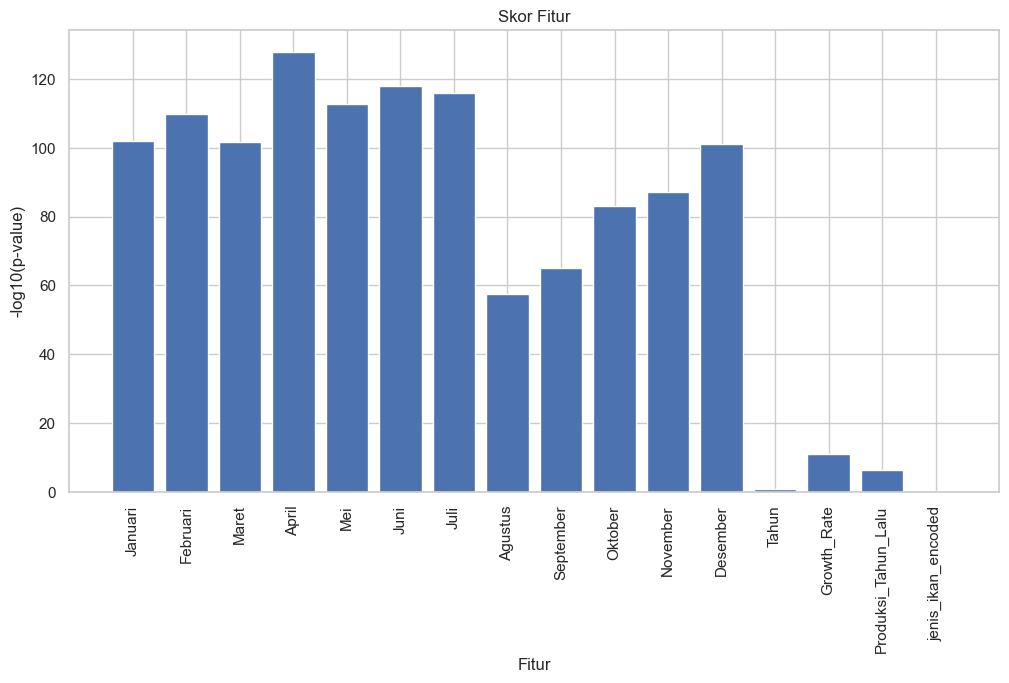

Fitur yang dipilih: Index(['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli',
       'Agustus', 'September', 'Oktober', 'November', 'Desember', 'Tahun',
       'Growth_Rate', 'Produksi_Tahun_Lalu'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Januari              163 non-null    float64
 1   Februari             163 non-null    float64
 2   Maret                163 non-null    float64
 3   April                163 non-null    float64
 4   Mei                  163 non-null    float64
 5   Juni                 163 non-null    float64
 6   Juli                 163 non-null    float64
 7   Agustus              163 non-null    float64
 8   September            163 non-null    float64
 9   Oktober              163 non-null    float64
 10  November             163 non-null    float64
 11  Desemb

In [6]:
# Definisikan fitur dan target
X = df.drop('Total_Produksi_Tahunan', axis=1)
y = df['Total_Produksi_Tahunan']

# Pilih fitur terbaik menggunakan SelectKBest
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

# Dapatkan skor setiap fitur
scores = -np.log10(selector.pvalues_)

# Plot skor fitur
plt.bar(X.columns, scores)
plt.xticks(rotation=90)
plt.xlabel('Fitur')
plt.ylabel('-log10(p-value)')
plt.title('Skor Fitur')
plt.show()

# Pilih fitur yang akan digunakan (misalnya, yang memiliki skor di atas ambang batas tertentu)
selected_features = X.columns[selector.scores_ > 1]  # Ubah ambang batas sesuai kebutuhan
X = X[selected_features]

# Tampilkan fitur yang dipilih
print(f"Fitur yang dipilih: {selected_features}")

# Info dataset setelah feature selection
print(X.info())


3. Pembagian Data


Dataset dibagi menjadi 80% data latih dan 20% data uji menggunakan train_test_split().



In [7]:
X = df.drop(columns=['Total_Produksi_Tahunan'])
y = df['Total_Produksi_Tahunan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


4. Pembangunan Model


In [8]:
# Inisialisasi model-model yang akan digunakan
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}


Tiga model regresi diuji untuk menentukan model terbaik:

Linear Regression
Random Forest Regressor
Gradient Boosting Regressor

a. Model Linear Regression

In [9]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Linear Regression - R²: {r2_lr}, MSE: {mse_lr}")


Linear Regression - R²: 1.0, MSE: 2.7745778430409414e-30


b. Model Random Forest

In [10]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest - R²: {r2_rf}, MSE: {mse_rf}")


Random Forest - R²: 0.9638022400957997, MSE: 0.07832356913435308


c. Model Gradient Boosting

In [11]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

r2_gb = r2_score(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f"Gradient Boosting - R²: {r2_gb}, MSE: {mse_gb}")


Gradient Boosting - R²: 0.988956968003102, MSE: 0.02389456370645612


Hyperparameter Tuning

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

# Definisikan fitur dan target
X = df.drop('Total_Produksi_Tahunan', axis=1)
y = df['Total_Produksi_Tahunan']

# Pilih fitur terbaik menggunakan SelectKBest
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

# Pilih fitur berdasarkan ambang batas
selected_features = X.columns[selector.scores_ > 1]  # Sesuaikan threshold jika perlu
X = X[selected_features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning untuk Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Hyperparameter tuning untuk Gradient Boosting
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'subsample': [0.8, 1.0]
}

gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)

# Dapatkan model terbaik
best_rf = rf_grid.best_estimator_
best_gb = gb_grid.best_estimator_

# Prediksi menggunakan model terbaik
y_pred_rf = best_rf.predict(X_test)
y_pred_gb = best_gb.predict(X_test)

# Evaluasi model terbaik
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

# Tampilkan hasil
print("Best Random Forest:")
print(f"  Params: {rf_grid.best_params_}")
print(f"  RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}")

print("\nBest Gradient Boosting:")
print(f"  Params: {gb_grid.best_params_}")
print(f"  RMSE: {rmse_gb:.4f}, R²: {r2_gb:.4f}")


Best Random Forest:
  Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  RMSE: 0.2713, R²: 0.9660

Best Gradient Boosting:
  Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
  RMSE: 0.1873, R²: 0.9838


Hasil Hyperparameter Tuning menunjukkan bahwa model Gradient Boosting Regressor (GBR) memberikan performa yang lebih baik dibandingkan Random Forest Regressor (RFR) berdasarkan metrik evaluasi Root Mean Squared Error (RMSE) dan R² Score.



1. Perbandingan Performa Model


RMSE (Root Mean Squared Error):

RMSE yang lebih rendah menunjukkan bahwa model memiliki kesalahan prediksi lebih kecil.
Gradient Boosting memiliki RMSE lebih kecil (0.1873) dibandingkan Random Forest (0.2713), menunjukkan bahwa model ini lebih akurat dalam memprediksi.

R² Score:

R² mengukur seberapa baik model menjelaskan variasi dalam data, dengan nilai 1.0 sebagai yang terbaik.
Gradient Boosting memiliki R² lebih tinggi (0.9838) dibandingkan Random Forest (0.9660), menunjukkan bahwa model ini lebih mampu menjelaskan variasi dalam dataset.

2. Analisis Hyperparameter yang Dipilih


Random Forest Regressor:


max_depth = 20 → Model lebih kompleks dengan kedalaman lebih besar, memungkinkan pemisahan lebih rinci dalam data.
min_samples_leaf = 1 → Setiap daun hanya memiliki satu sampel minimum, meningkatkan fleksibilitas model tetapi berpotensi menyebabkan overfitting.
min_samples_split = 2 → Node akan terus membelah jika memiliki setidaknya 2 sampel, yang merupakan default.
n_estimators = 200 → Model menggunakan 200 pohon, lebih tinggi dari default (100), meningkatkan stabilitas prediksi.

Implikasi:

Kelebihan: Model memiliki kompleksitas tinggi, dapat menangkap pola yang lebih rumit.

Kekurangan: Potensi overfitting karena kedalaman tinggi dan daun minimum kecil.

Gradient Boosting Regressor:

learning_rate = 0.1 → Kecepatan pembelajaran yang umum digunakan, memberikan keseimbangan antara kecepatan dan akurasi.
max_depth = 3 → Kedalaman kecil, membuat model lebih sederhana, mengurangi risiko overfitting.
n_estimators = 200 → Lebih banyak iterasi boosting, meningkatkan akurasi prediksi secara bertahap.
subsample = 1.0 → Menggunakan 100% data dalam setiap iterasi boosting, menghasilkan model yang lebih stabil.

Implikasi:

Kelebihan:
Model lebih tahan terhadap overfitting dengan kedalaman yang lebih rendah.
Learning rate yang optimal menjaga keseimbangan antara kecepatan dan kinerja model.
Subsampling penuh membantu model belajar dari keseluruhan dataset tanpa kehilangan informasi penting.

Kekurangan:
Bisa lebih lambat dibandingkan Random Forest karena proses boosting bertahap.

Kesimpulan:
Gradient Boosting menggunakan kedalaman lebih kecil dan learning rate yang sesuai, sehingga lebih stabil dan memiliki generalizability lebih baik dibandingkan Random Forest.



3. Kesimpulan & Rekomendasi


Model terbaik berdasarkan tuning: Gradient Boosting Regressor (GBR) karena memiliki RMSE lebih kecil dan R² lebih tinggi.
Random Forest tetap kompetitif, tetapi berisiko overfitting karena kedalaman yang tinggi.
Jika fokus pada akurasi tinggi dengan data yang kompleks, GBR adalah pilihan terbaik.
Jika ingin model lebih cepat dan lebih mudah diinterpretasi, Random Forest bisa tetap digunakan.

Rekomendasi selanjutnya:

Coba menurunkan learning rate (misalnya 0.05) untuk melihat apakah ada peningkatan lebih lanjut pada GBR.
Gunakan Cross-Validation lebih banyak (misalnya 10-fold CV) untuk menguji stabilitas model.
Lakukan Feature Engineering lebih lanjut untuk meningkatkan akurasi kedua model.

model deploy

In [15]:
import joblib

# Simpan hasil evaluasi model dalam dictionary
tuned_results = {
    'Random Forest': {'R2': r2_rf, 'model': best_rf},
    'Gradient Boosting': {'R2': r2_gb, 'model': best_gb}
}

# Pilih model dengan nilai R² tertinggi
best_model_name = max(tuned_results, key=lambda k: tuned_results[k]['R2'])
best_model = tuned_results[best_model_name]['model']

# Simpan model terbaik ke dalam file .pkl
joblib.dump(best_model, 'best_production_model.pkl')

print(f"Model terbaik ({best_model_name}) disimpan sebagai 'best_production_model.pkl'")


Model terbaik (Gradient Boosting) disimpan sebagai 'best_production_model.pkl'
